# Disjunctive Programming
Let's compare two different approaches to disjunctive programming: Big-M and convex hull. 

## A simple problem
minimize $ x^\top Q x + q^\top x $

subject to:
$$
\begin{aligned}
x \in R_1 \cup R_2\\
x_{lb} \leq x \leq x_{ub}
\end{aligned}
$$

where $R_i$ is a polyhedron specified by
$$
R_i \equiv \{ x\  |\  A_i x \leq b_i \}
$$

## Binary variables
We'll rewrite the above problem by introducing binary variables $z_i$:

minimize $ x^\top Q x + q^\top x $

over $x$, $z_i$

subject to:
$$
\begin{aligned}
z_1 = 1 \implies x \in R_1\\
z_2 = 1 \implies x \in R_2\\
z_i \in \{0, 1\}\\
\sum_i z_i = 1\\
x_{lb} \leq x \leq x_{ub}
\end{aligned}
$$


## Big-M
The big-M formulation lets us convert the implies operators into linear constraints:

$$
z_i = 1 \implies x \in R_i
$$

becomes

$$
A_i x + M z_i \leq b_i + M
$$

If M is sufficiently big, then when $z_i$ is $0$, the constraint becomes trivial, and when $z_i$ is $1$, the constraint becomes exactly $x \in R_1$. 


# Implementation
## Generating regions
We'll generate the regions as the convex hull of some random points:

In [124]:
using CHull

In [125]:
function hull_points(P::Array{Float64,2})
    hull = chull(P)
    hull_pts = Array(Float64, size(hull.vertices, 1) + 1, size(P, 2))
    line_segments = Dict{Int64,Int64}()
    for i in 1:size(hull.vertices, 1)
        line_segments[hull.vertices[i,1]] = hull.vertices[i,2]
    end
    start = hull.vertices[1,1]
    hull_pts[1,:] = P[start,:]
    for i = 1:size(hull.vertices, 1)
        start = line_segments[start]
        hull_pts[i+1,:] = P[start,:]
    end
    return hull_pts
end
    

hull_points (generic function with 1 method)

In [126]:
dim = 2
num_regions = 10
P = Array{Float64,2}[]
A = Array{Float64,2}[]
b = Array{Float64,2}[]
R = [0 1; -1 0]

for j in 1:num_regions
    P_unordered = rand(4, dim) .+ [j 0]
    push!(P, hull_points(P_unordered))
    push!(A, Array(Float64, size(P[j], 1) - 1, size(P[j])[2]))
    push!(b, Array(Float64, size(A[j], 1), 1))
    for i in 1:size(P[j], 1)-1
        v = P[j][i+1, :] - P[j][i, :]
        
        A[j][i,:] = (R * v.')
        A[j][i,:] = A[j][i,:] ./ norm(A[j][i,:])
        b[j][i,:] = (A[j][i,:] * P[j][i,:].')
    end
end
x_lb = 0
x_ub = num_regions + 2
x_goal = [num_regions / 2; 1.5]

2-element Array{Float64,1}:
 5.0
 1.5

In [127]:
using JuMP

In [128]:
bigM = Model()

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver set to Default

In [129]:
@defVar(bigM, x[1:dim])

2-element Array{Variable,1}:
 x[1]
 x[2]

In [130]:
@defVar(bigM, z[1:num_regions], Bin)

10-element Array{Variable,1}:
 z[1] 
 z[2] 
 z[3] 
 z[4] 
 z[5] 
 z[6] 
 z[7] 
 z[8] 
 z[9] 
 z[10]

In [131]:
@addConstraint(bigM, sum(z) == 1)

z[1] + z[2] + z[3] + z[4] + z[5] + z[6] + z[7] + z[8] + z[9] + z[10] = 1

In [132]:
M = 100
for i in 1:num_regions
    @addConstraint(bigM, A[i] * x .+ M * z[i] .<= b[i] .+ M)
end


In [133]:
@addConstraint(bigM, x_lb .<= x)
@addConstraint(bigM, x .<= x_ub)

2-element Array{ConstraintRef{GenericRangeConstraint{GenericAffExpr{Float64,Variable}}},1}:
 x[1] ≤ 12
 x[2] ≤ 12

In [134]:
@setObjective(bigM, Min, sum((x - x_goal).^2))

:Min

In [135]:
bigM

Minimization problem with:
 * 42 linear constraints
 * 12 variables: 10 binary
Solver set to Default

In [136]:
status = solve(bigM)

Optimize a model with 42 rows, 12 columns and 125 nonzeros
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range    [1e-02, 1e+02]
  Objective range [3e+00, 1e+01]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+02]
Found heuristic solution: objective -16.5551
Presolve removed 4 rows and 0 columns
Presolve time: 0.00s
Presolved: 38 rows, 12 columns, 454 nonzeros
Presolved model has 2 quadratic objective terms
Variable types: 2 continuous, 10 integer (10 binary)

Root relaxation: objective -2.703119e+01, 30 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -27.03119    0    3  -16.55511  -27.03119  63.3%     -    0s
H    0     0                     -25.8254962  -27.03119  4.67%     -    0s
     0     0  -27.01850    0    4  -25.82550  -27.01850  4.62%     -    0s
     0     0  -27.01844    0    3  -25.82550  -27

:Optimal

In [137]:
using PyPlot

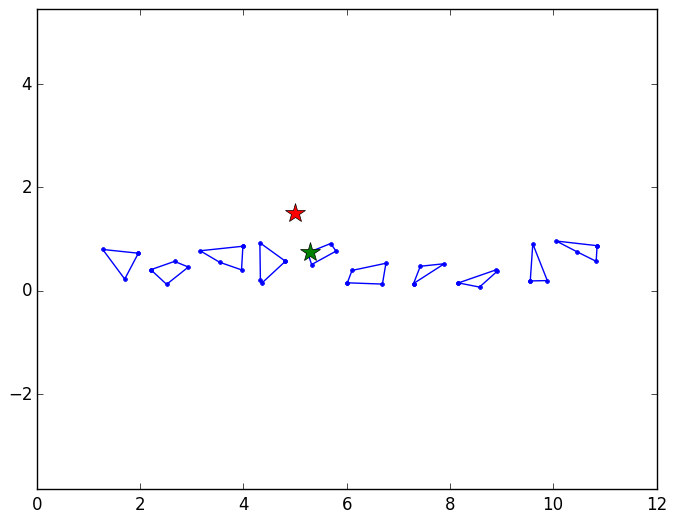

(0.0,12.0,0.0,1.6)

In [150]:
figure()
hold(1)
for j in 1:num_regions
    plot(P[j][:,1], P[j][:,2], "b.-")
end
plot([getValue(x[1])], [getValue(x[2])], "g*", markersize=15, markerfacecolor="g")
plot([x_goal[1]], [x_goal[2]], "r*", markersize=15)
axis("equal")

## Convex Hull formulation
minimize $ x^\top Q x + q^\top x $

subject to:
$$
\begin{aligned}
v &= u_1 + u_2\\
A_1 u_1 &\leq y_1 b_1\\
A_2 u_2 &\leq y_2 b_2\\
y_1 x_{lb} &\leq u_1 \leq y_1 x_{ub}\\
y_2 x_{lb} &\leq u_2 \leq y_2 x_{ub}\\
y_i &\in \{0, 1\}
\end{aligned}
$$

where $R_i$ is a polyhedron specified by
$$
R_i \equiv \{ x\  |\  A_i x \leq b_i \}
$$




In [139]:
conv = Model()

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver set to Default

In [140]:
@defVar(conv, v[1:dim])

2-element Array{Variable,1}:
 v[1]
 v[2]

In [141]:
@defVar(conv, u[1:num_regions, 1:dim])

10x2 Array{Variable,2}:
 u[1,1]   u[1,2] 
 u[2,1]   u[2,2] 
 u[3,1]   u[3,2] 
 u[4,1]   u[4,2] 
 u[5,1]   u[5,2] 
 u[6,1]   u[6,2] 
 u[7,1]   u[7,2] 
 u[8,1]   u[8,2] 
 u[9,1]   u[9,2] 
 u[10,1]  u[10,2]

In [142]:
@defVar(conv, y[1:num_regions], Bin)

10-element Array{Variable,1}:
 y[1] 
 y[2] 
 y[3] 
 y[4] 
 y[5] 
 y[6] 
 y[7] 
 y[8] 
 y[9] 
 y[10]

In [143]:
@addConstraint(conv, sum(y) == 1)

y[1] + y[2] + y[3] + y[4] + y[5] + y[6] + y[7] + y[8] + y[9] + y[10] = 1

In [144]:
for i in 1:num_regions
    @addConstraint(conv, A[i] * (u[i,:].') .<= y[i] .* b[i])
end

In [145]:
for i in 1:num_regions
    @addConstraint(conv, y[i] * x_lb .<= u[i,:])
    @addConstraint(conv, u[i,:] .<= y[i] * x_ub)
end

In [146]:
@defExpr(sum_u, sum{u[i,:], i=1:num_regions})
@addConstraint(conv, v .== vec(sum_u))

2-element Array{ConstraintRef{GenericRangeConstraint{GenericAffExpr{Float64,Variable}}},1}:
 v[1] - u[1,1] - u[2,1] - u[3,1] - u[4,1] - u[5,1] - u[6,1] - u[7,1] - u[8,1] - u[9,1] - u[10,1] = 0
 v[2] - u[1,2] - u[2,2] - u[3,2] - u[4,2] - u[5,2] - u[6,2] - u[7,2] - u[8,2] - u[9,2] - u[10,2] = 0

In [147]:
@setObjective(conv, Min, sum((v - x_goal).^2))

:Min

In [148]:
status = solve(conv)

Optimize a model with 80 rows, 32 columns and 203 nonzeros
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range    [1e-02, 1e+01]
  Objective range [3e+00, 1e+01]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+00]
Found heuristic solution: objective -16.5551
Presolve removed 28 rows and 0 columns
Presolve time: 0.00s
Presolved: 52 rows, 32 columns, 167 nonzeros
Presolved model has 2 quadratic objective terms
Variable types: 22 continuous, 10 integer (10 binary)

Root relaxation: objective -2.692855e+01, 96 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -26.92855    0    2  -16.55511  -26.92855  62.7%     -    0s
H    0     0                     -26.5085262  -26.92855  1.58%     -    0s
     0     2  -26.92855    0    2  -26.50853  -26.92855  1.58%     -    0s
*    3     1               3     -26.6093997  -

:Optimal

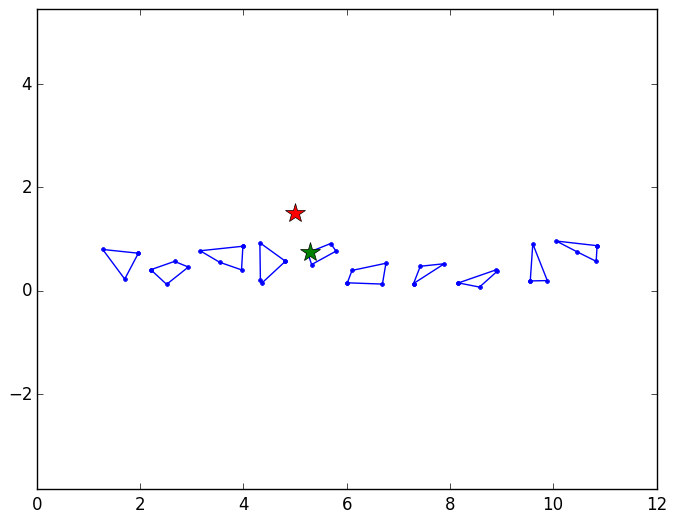

(0.0,12.0,0.0,1.6)

In [151]:
figure()
hold(1)
for j in 1:num_regions
    plot(P[j][:,1], P[j][:,2], "b.-")
end
plot([getValue(v[1])], [getValue(v[2])], "g*", markersize=15, markerfacecolor="g")
plot([x_goal[1]], [x_goal[2]], "r*", markersize=15)
axis("equal")